In [242]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx
import geopandas as gpd
import eurostat
import requests
import urllib.parse
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from matplotlib.colors import ListedColormap

In [91]:
shapefile_data = gpd.read_file("/Users/joebacchus/Desktop/Bartlett CASA/NUTS Shapefiles/NUTS_RG_20M_2021_3035.shp")
citations_data = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Citation data/202001_PCT_CITATIONS.txt", sep="|")
patents_data = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_PCT_Inv_reg.txt", sep="|")
associated_IPC = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_PCT_IPC.txt", sep="|")
IPC_translations = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/All_IPC.txt", sep="	")

In [260]:
# Restricting to UK and selected NUTS
NUTS_level = 3
space_GB = shapefile_data.loc[shapefile_data['CNTR_CODE'] == "UK"] # Can modify UK
space_GB = shapefile_data
space_GB_NUTS = space_GB.loc[shapefile_data['LEVL_CODE'] == NUTS_level]
space_GB_NUTS

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
322,DE254,3,DE,"Nürnberg, Kreisfreie Stadt","Nürnberg, Kreisfreie Stadt",4.0,1,3,DE254,"POLYGON ((4395582.127 2936362.696, 4406400.516..."
323,DE255,3,DE,"Schwabach, Kreisfreie Stadt","Schwabach, Kreisfreie Stadt",4.0,1,3,DE255,"POLYGON ((4399487.535 2914611.100, 4399340.230..."
324,DE256,3,DE,"Ansbach, Landkreis","Ansbach, Landkreis",4.0,3,3,DE256,"POLYGON ((4371588.633 2925060.496, 4384059.306..."
325,DE257,3,DE,Erlangen-Höchstadt,Erlangen-Höchstadt,4.0,1,3,DE257,"POLYGON ((4387812.619 2962178.867, 4400140.051..."
402,DE258,3,DE,"Fürth, Landkreis","Fürth, Landkreis",4.0,1,3,DE258,"POLYGON ((4388620.345 2936169.261, 4388106.308..."
...,...,...,...,...,...,...,...,...,...,...
2004,TRC13,3,TR,Kilis,Kilis,3.0,2,2,TRC13,"POLYGON ((6747420.020 1958428.358, 6712801.038..."
2005,TRC21,3,TR,Şanlıurfa,Şanlıurfa,4.0,2,3,TRC21,"POLYGON ((6904684.585 2120354.802, 6938677.828..."
2006,TRC22,3,TR,Diyarbakır,Diyarbakır,4.0,2,3,TRC22,"POLYGON ((6989716.599 2273670.524, 6982786.486..."
2007,NO0B2,3,NO,Svalbard,Svalbard,3.0,3,1,NO0B2,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."


In [261]:
COUNTRY_CODE = 'GB'

# Restricting patents data to GB
GB_patents = patents_data.loc[patents_data['ctry_code'] == COUNTRY_CODE] # Can modify GB
GB_patent_ids = np.array(list(patents_data_GB['appln_id'])).astype(int)
GB_patents

,pct_nbr,internat_appln_nr,appln_id,inv_name,address,reg_code,ctry_code,reg_share,inv_share
2,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000
4,WO1978000006,WO1978CH00002,6508282.0,"Erskine, William Graham",Morpeth Northumberland NE61 2YL,UKC21,GB,1.0,0.500000
25,WO1979000002,WO1978GB00002,22653862.0,"MARTIN, Archer, John, Porter","Elstree, Hertfordshire",UKH23,GB,1.0,0.500000
26,WO1979000002,WO1978GB00002,22653862.0,"HAMPSON, Frank","Lewes, Sussex",UKJ22,GB,1.0,0.500000
83,WO1979000070,WO1978GB00007,22653867.0,"Joseph, Simon Philip",London S.W.13,UKI11,GB,1.0,1.000000
...,...,...,...,...,...,...,...,...,...
9551495,WO2019143945,WO2019US14204,507304944.0,"NELSON, Drew",Cowbridge Vale of Glamorgan CF71 7RW,UKL22,GB,1.0,0.166667
9551562,WO2019143970,WO2019US14240,516857277.0,"FREEMAN, Toby",Nottingham NG16 6NT,UKF12,GB,1.0,0.333333
9551922,WO2019144081,WO2019US14427,507605603.0,"BRADLEY, Richard",Leicestershire LE14 4RT,UKF22,GB,1.0,0.200000
9551988,WO2019144099,WO2019US14490,507304994.0,"DROZDOV, Ignat",Warwick Warwickshire CV34 4BP,UKG13,GB,1.0,0.333333


In [262]:
# Restricting patents data to GB
GB_citations = citations_data[citations_data['Citing_appln_id'].isin(GB_patent_ids)]
GB_citations = pd.DataFrame(GB_citations)
GB_patent_ids_n = list(GB_citations['Citing_pub_nbr'].unique())
GB_citations

,Citing_pub_nbr,Citing_pub_date,Citing_app_nbr,Citing_appln_id,Cited_pub_nbr,Cited_pub_date,Cited_App_auth,Cited_App_nbr,Cited_Appln_id,Cit_Total,Citn_origin,Citn_category,Citn_lag_year,Citn_lag_month,ISA
19,WO1978000004,19781207,WO1978000001,22653861,DE917288,19540830.0,DE,DEF0004084,12001407.0,4,ISR,A,24.0,292.0,EP
20,WO1978000004,19781207,WO1978000001,22653861,FR622319,19270528.0,FR,FR622319D,19436436.0,4,ISR,X,51.0,619.0,EP
21,WO1978000004,19781207,WO1978000001,22653861,FR981955,19510601.0,FR,FR981955D,20592021.0,4,ISR,A,27.0,330.0,EP
22,WO1978000004,19781207,WO1978000001,22653861,GB190900124,19090715.0,GB,GB190900124D,23575988.0,4,ISR,X,69.0,833.0,EP
29,WO1978000006,19781207,WO1978000002,6508282,DE1904888,19690911.0,DE,DE1904888,9706327.0,8,ISR,NaN,9.0,111.0,EP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18950079,WO2019144081,20190725,WO2019014427,507605603,WO2016077484,20160519.0,WO,WO2015060204,456133658.0,10,ISR,I,3.0,38.0,EP
18950187,WO2019144099,20190725,WO2019014490,507304994,EP2169078,20100331.0,EP,EP2008380279,55899494.0,3,ISR,A,9.0,112.0,EP
18950188,WO2019144099,20190725,WO2019014490,507304994,WO2010061996,20100603.0,WO,WO2008007173,315831418.0,3,ISR,A,9.0,109.0,EP
18950189,WO2019144099,20190725,WO2019014490,507304994,WO2012103250,20120802.0,WO,WO2012022594,365539563.0,3,ISR,A,7.0,83.0,EP


In [267]:
quantity = 5000

#full = len(GB_patent_ids_n)

store_cit_share = np.zeros(quantity)
for i in tqdm(range(quantity)):
    countries_cited = list((GB_citations.loc[GB_citations['Citing_pub_nbr'] == GB_patent_ids_n[i]])['Cited_App_auth'])
    GB_count = countries_cited.count(COUNTRY_CODE)/len(countries_cited)
    store_cit_share[i] = GB_count
    
share_table = pd.DataFrame(np.stack((GB_patent_ids_n[:quantity], store_cit_share), axis=1),columns=['pct_nbr','Share'])

100%|███████████████████████████████████████| 5000/5000 [04:39<00:00, 17.90it/s]


In [268]:
Assigned_shapefile = GB_patents.merge(share_table, left_on='pct_nbr', right_on='pct_nbr')
Assigned_shapefile = space_GB_NUTS.merge(Assigned_shapefile, left_on='NUTS_ID', right_on='reg_code')

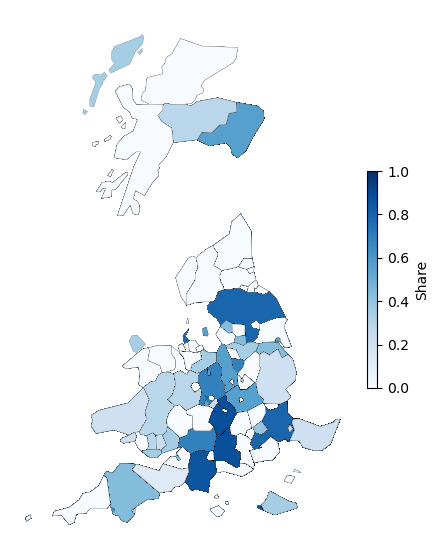

In [269]:
# Plotting
cmap = 'Blues'
Assigned_shapefile.plot(figsize=(7,7), column='Share', cmap=cmap, linewidth=0.1, edgecolor='black')
norm = plt.Normalize(Assigned_shapefile['Share'].min(), Assigned_shapefile['Share'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, fraction=0.02, pad=0.02)

cbar.set_label('Share')

plt.axis("off")
plt.show()

In [115]:
# Modifiable parameters
NUTS_level = 3
IPC_level = 1

# Loading shapefile and restricting to UK and selected NUTS
space_GB = space.loc[space['CNTR_CODE'] == "UK"]
space_GB_NUTS3 = space_GB.loc[space['LEVL_CODE'] == NUTS_level]

# Restricting citations data to UK
citations_data_GB = citations_data.loc[citations_data['ctry_code'] == "GB"]

# Merging citations and shapefile
merged_data = space_GB_NUTS3.merge(citations_data_GB, left_on='FID', right_on='reg_code')

IPC_reduced = IPC_translations.loc[IPC_translations['IPC'].str.len()==IPC_level]
merged_data["IPC"] = merged_data["IPC"].str[0:IPC_level]
merged_data_named = merged_data.merge(IPC_reduced, left_on='IPC', right_on='IPC')

contents = np.sort(list(merged_data_named["IPC"].unique())) # All possible IPC
dates = np.sort(list(merged_data_named["prio_year"].unique())) # All possible IPC

In [116]:
select = 5
merged_data_named_year = merged_data_named.loc[merged_data_named['prio_year'] == dates[select]] # Full data
edge_list = np.array(merged_data_named_year[['Citing_appln_id', 'Cited_Appln_id']]) # Creating edge list
merged_data_named.loc[merged_data_named['Citing_appln_id'] == int(np.array(graph.nodes())[7])]['prio_year'].unique()

array([1980])

In [117]:
graph = nx.DiGraph()
graph.add_edges_from(edge_list)
for i in range(len(np.array(graph.nodes()))):
    graph.add_node(np.array(graph.nodes())[i], date=merged_data_named.loc[merged_data_named['Citing_appln_id'] == int(np.array(graph.nodes())[7])]['prio_year'].unique())

In [114]:
graph.nodes(data=True)

NodeDataView({16531370.0: {'date': array([1980])}, 16454918.0: {'date': array([1980])}, 16533173.0: {'date': array([1980])}, 16478577.0: {'date': array([1980])}, 16534560.0: {'date': array([1980])}, 16501862.0: {'date': array([1980])}, 16538289.0: {'date': array([1980])}, 16481968.0: {'date': array([1980])}, 16538700.0: {'date': array([1980])}, 16508981.0: {'date': array([1980])}, 16530156.0: {'date': array([1980])}, 16453081.0: {'date': array([1980])}, 16530046.0: {'date': array([1980])}, 16478042.0: {'date': array([1980])}, 16533512.0: {'date': array([1980])}, 16452255.0: {'date': array([1980])}, 16593382.0: {'date': array([1980])}, 16531258.0: {'date': array([1980])}, 16439042.0: {'date': array([1980])}, 258649.0: {'date': array([1980])}, 258639.0: {'date': array([1980])}, 16532616.0: {'date': array([1980])}, 16562506.0: {'date': array([1980])}, 16527415.0: {'date': array([1980])}, 16437629.0: {'date': array([1980])}, 16439222.0: {'date': array([1980])}, 16533601.0: {'date': array([

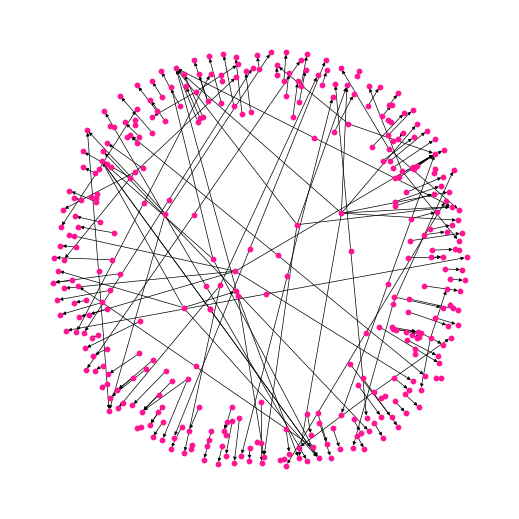

In [57]:
plt.figure(figsize=(5,5))
nx.draw(graph,  
        with_labels = False,
        node_color='deeppink',
        node_size=10,
        width=0.5,
        arrowsize=5,
        font_color="black",
        font_size=2)